In [1]:
from sqlalchemy import create_engine
import pandas as pd

engine = create_engine('postgresql://postgres:postgres@db:5432/postgres')

In [2]:
def read_file(script_path):
    """
    helper function to read sql script file and return sqlalchemy textual sql
    """
    from sqlalchemy.sql import text
    with open(script_path, 'r') as sql_file:
        sql_query = sql_file.read()

    return text(sql_query)

#### Daily, Weekly and Monthly average number of trips per region

In [3]:
sql = read_file('../scripts/avgs_by_region.sql')
df = pd.read_sql_query(sql,con=engine)
df

,region,daily_avg,weekly_avg,monthly_avg
0,Turin,1.727273,7.6,38.0
1,Hamburg,1.333333,5.6,28.0
2,Prague,1.619048,6.8,34.0


#### What regions has the "cheap_mobile" datasource appeared in?

In [4]:
sql = read_file('../scripts/cheap_mobile_counts.sql')
df = pd.read_sql_query(sql,con=engine)
df

,region,cheap_mobile_appearances
0,Prague,13
1,Hamburg,10
2,Turin,10


#### From the two most commonly appearing regions, which is the latest datasource?

In [5]:
sql = read_file('../scripts/latest_datasources.sql')
df = pd.read_sql_query(sql,con=engine)
df

,region,latest_datasource
0,Turin,pt_search_app
1,Prague,cheap_mobile


#### Trip distances in Km

In [6]:
sql =  """
    SELECT region, 
           round(cast(ST_Distance(orig_coord, dest_coord)/1000 as numeric), 2) AS distance_in_km, 
           datetime,
           datasource
      FROM trips
"""
df = pd.read_sql_query(sql,con=engine)
df.head()

,region,distance_in_km,datetime,datasource
0,Hamburg,25.59,2018-05-21 20:53:22,cheap_mobile
1,Hamburg,20.99,2018-05-14 01:47:52,baba_car
2,Hamburg,16.33,2018-05-12 16:40:40,bad_diesel_vehicles
3,Hamburg,17.22,2018-05-21 19:13:24,cheap_mobile
4,Hamburg,4.48,2018-05-04 00:46:12,cheap_mobile


#### Working with bounding boxes and Postgis spatial queries

In [7]:
# Weekly Average number of trips in Hamburg

sql = """
with hamburg_envelope as (
select ST_MakeEnvelope(min(ST_XMin(orig_coord::geometry)), -- xmin (min lng)
                       min(ST_YMin(orig_coord::geometry)), -- ymin (min lat)
                       max(ST_XMax(orig_coord::geometry)), -- xmax (max lng)
                       max(ST_YMax(orig_coord::geometry)), -- ymax (max lat)
                       4326 -- projection epsg-code
                       )::geography('POLYGON') env
 from trips 
where region = 'Hamburg')


SELECT region, avg(count) weekly_avg
  FROM (SELECT region, count(*)
          FROM trips
         WHERE ST_Intersects(ST_MakeLine(orig_coord::geometry, dest_coord::geometry), (select env from hamburg_envelope))
         GROUP BY region, date_trunc('week', datetime)) s
 GROUP BY 1
"""
df = pd.read_sql_query(sql,con=engine)
df

,region,weekly_avg
0,Hamburg,5.6


#### Plotting trips (Turin)

In [8]:
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon

con = engine.connect()

sql = "SELECT ST_MakeLine(orig_coord::geometry, dest_coord::geometry) geom FROM trips where region = 'Turin'"
lines = gpd.GeoDataFrame.from_postgis(sql, con)

sql = "SELECT orig_coord::geometry geom FROM trips where region = 'Turin'"
origin = gpd.GeoDataFrame.from_postgis(sql, con)

sql = "SELECT dest_coord::geometry geom FROM trips where region = 'Turin'"
destination = gpd.GeoDataFrame.from_postgis(sql, con)

turin_shape = gpd.read_file('../data/shapes/turin_roads.shx')

(44.96612466562052, 45.14930102848315)

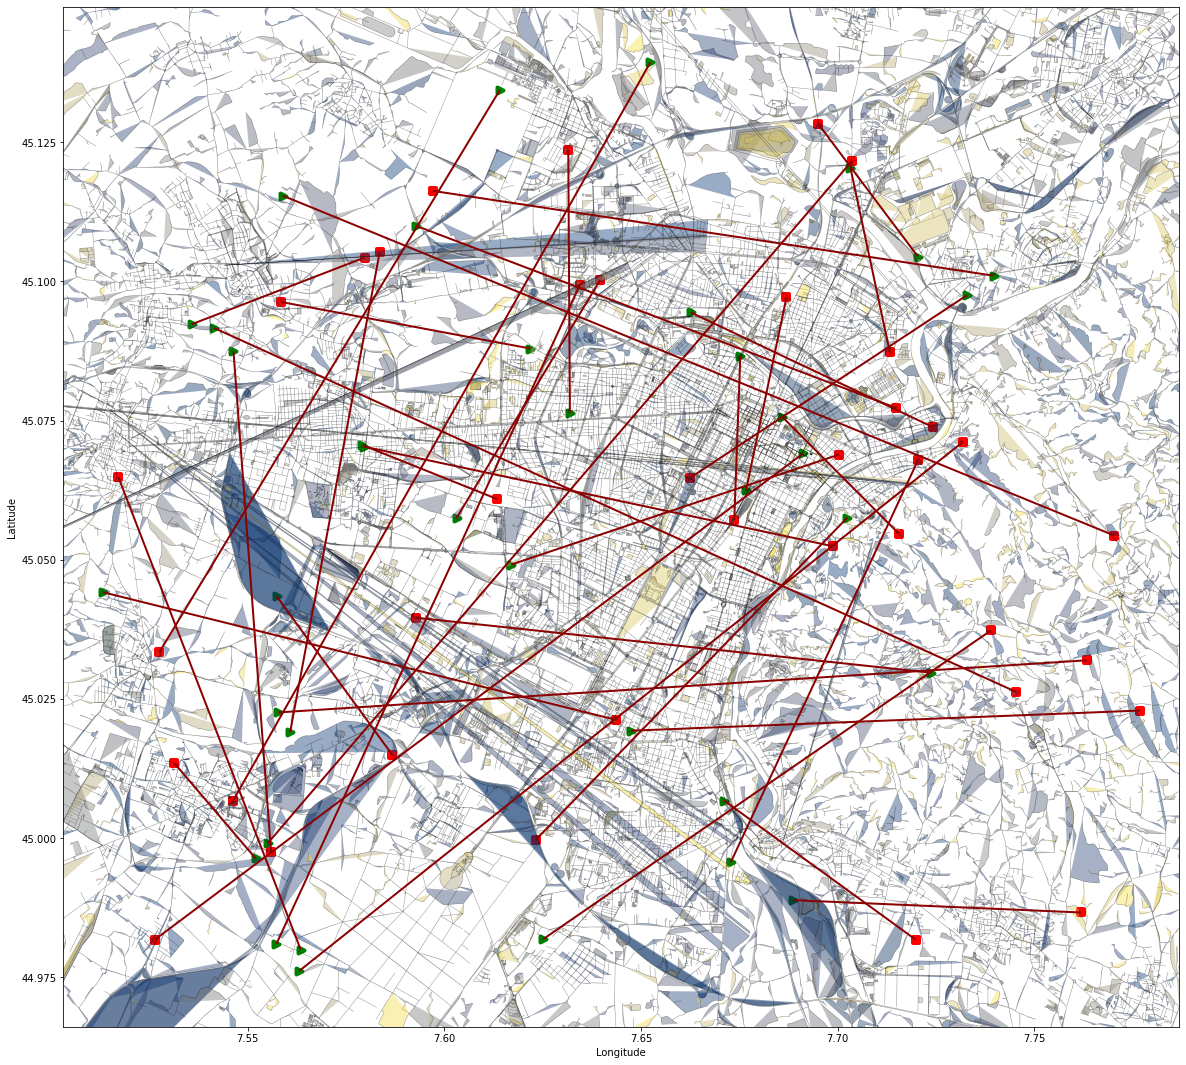

In [9]:
fig, ax = plt.subplots(figsize=(20,20))

turin_shape.plot(ax=ax, 
                 facecolor='Grey', 
                 alpha=0.4, 
                 edgecolor='k', 
                 linewidth=0.5, 
                 cmap="cividis")

lines.plot(ax=ax, color='darkred', markersize=5, linewidth=2)
origin.plot(ax=ax, color='green', marker='>', linewidth=4)
destination.plot(ax=ax, color='red', marker='s', linewidth=4)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

minx, miny, maxx, maxy = lines.total_bounds
ax.set_xlim(minx-0.01, maxx+0.01)
ax.set_ylim(miny-0.01, maxy+0.01)